In [3]:
import config
import paths
from cnn_builder import *
from config import *
from dataset_functions import *
from hypercube_set import HypercubeSet
from hypercube_loader import *
import numpy as np
import rendering
import training_history

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
os.chdir(os.getcwd().split("jupyter")[0])

inf = 2e32

%load_ext autoreload
%autoreload 2

read_json_config(paths.config_file, network_type=None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
hc_set = HypercubeSet(hc_array=load_hypercubes(plot_hc=False, plot_mask=False, n_max_cubes=inf))
hc_set.print_metadata()

Reading media/Mateus_2021/white\raw_10208_rf.hdr ...
Reading media/Mateus_2021/white\raw_12400_rf.hdr ...
Reading media/Mateus_2021/white\raw_14400_rf.hdr ...
Reading media/Mateus_2021/white\raw_16592_rf.hdr ...
Reading media/Mateus_2021/white\raw_18592_rf.hdr ...
Reading media/Mateus_2021/white\raw_20912_rf.hdr ...
Reading media/Mateus_2021/white\raw_22912_rf.hdr ...
Reading media/Mateus_2021/white\raw_4128_rf.hdr ...
Reading media/Mateus_2021/white\raw_6128_rf.hdr ...
Reading media/Mateus_2021/white\raw_8208_rf.hdr ...
Min: 0.010506520979106426, Max: 0.23533053696155548, Size: (2000, 6400, 223)


In [9]:
hc_set.obtain_ground_labels()
hc_set.obtain_train_indices(test_percentage=test_split, patch_size=config.patch_size, patch_overlapping=config.patch_overlapping)

In [10]:
X_train_01, y_train_01 = hc_set.split_train(patch_size=config.patch_size)
y_train_01_reduced = reduce_labels_center(y_train_01)

|████████████████████████████████████████| 79951/79951 [100%] in 0.4s (234374.46/s)                                     


In [11]:
hc_set.standardize()

(4833280, 223)
(4833280,)
on 0: (0, 223)                                                                                                          
|⚠︎                                       | (!) 0/2 [0%] in 0.0s (0.00/s)                                                


ValueError: Found array with 0 sample(s) (shape=(0, 223)) while a minimum of 1 is required by FactorAnalysis.

In [ ]:
X_train, y_train = hc_set.split_train(patch_size=config.patch_size)
y_train = reduce_labels_center(y_train)

In [ ]:
print(len(X_train))

In [ ]:
X_test, y_test = hc_set.split_test(patch_size=patch_size)
y_test = reduce_labels_center(y_test)

In [ ]:
render_mask_histogram(y_train)
render_mask_histogram(y_test)

In [ ]:
(patch, patch_label), rest_patch, rest_label = balance_classes(X_train, y_train, reduce=True, clustering=False)
(rest_patch, rest_label), _, _ = balance_classes(rest_patch, rest_label, reduce=True, clustering=False)

In [ ]:
X_train, y_train = [], []
X_train.append(patch)
X_train.append(rest_patch)
y_train.append(patch_label)
y_train.append(rest_label)
#vegetation_indices = np.where(y_train[1] == 0)
#X_train[1] = np.delete(X_train[1], vegetation_indices)
#y_train[1] = np.delete(y_train[1], vegetation_indices)

In [ ]:
(X_test, y_test), _, _ = balance_classes(X_test, y_test, reduce=True, clustering=False)

In [ ]:
render_mask_histogram(y_train[1])

In [ ]:
X_train_flatten = get_center(X_train[0])
X_train_augment, y_train_augmented = augment_chunks(X_train[0], y_train[0])

In [40]:
network_type = 'allopezr_2d'
read_json_config(paths.config_file, network_type=network_type)

network_name = get_name(network_type)
num_classes = hc_set.get_num_classes()
img_shape = X_train[0][0].shape

history = training_history.TrainingHistory(accuracy_name='sparse_categorical_accuracy')
callbacks, time_callback = get_callback_list(model_name=network_name)
model = build_network(network_type=network_type, num_classes=num_classes, image_dim=img_shape)
compile_network(model, network_type, network_name, num_classes, show_summary=True, render_image=True)
history.append_history(run_model(model, X_train_augment, y_train_augmented, validation_split=validation_split, callbacks=callbacks).history, time_callback)

{'optimizer': <keras.optimizers.optimizer_v2.rmsprop.RMSprop object at 0x000002BD92101670>, 'callbacks': [], 'intermediate_activation': 'relu', 'kernel_size': 3, 'start_size': 16, 'strides': 2}
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 21, 21, 30)  0           []                               
                                ]                                                                 
                                                                                                  
 reshape_16 (Reshape)           (None, 441, 30)      0           ['input_9[0][0]']                
                                                                                                  
 lambda_8 (Lambda)              (None, 441, 30)      0           ['reshape_16[0][0]']           

# Rendering and results

In [39]:
history.append_history(run_model(model, X_train_augment, y_train_augmented, validation_split=validation_split, callbacks=callbacks).history, time_callback)
history.save(network_name)

Training for 5 epochs with batch size of 256...
Epoch 1/5
378/379 [============================>.] - ETA: 0s - loss: 0.1873 - sparse_categorical_accuracy: 0.9365
Epoch 1: val_loss improved from 0.15266 to 0.14652, saving model to results/network\allopezr_2d_21x15_16.h5
379/379 [==============================] - 10s 25ms/step - loss: 0.1873 - sparse_categorical_accuracy: 0.9365 - val_loss: 0.1465 - val_sparse_categorical_accuracy: 0.9528
Epoch 2/5
378/379 [============================>.] - ETA: 0s - loss: 0.1814 - sparse_categorical_accuracy: 0.9384
Epoch 2: val_loss did not improve from 0.14652
379/379 [==============================] - 9s 23ms/step - loss: 0.1815 - sparse_categorical_accuracy: 0.9384 - val_loss: 0.1905 - val_sparse_categorical_accuracy: 0.9346
Epoch 3/5
379/379 [==============================] - ETA: 0s - loss: 0.1718 - sparse_categorical_accuracy: 0.9420
Epoch 3: val_loss improved from 0.14652 to 0.14341, saving model to results/network\allopezr_2d_21x15_16.h5
379/37

In [14]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss: " + str(test_loss) + ", Test Accuracy: " + str(test_accuracy))

194/194 [==============================] - 1s 5ms/step - loss: 0.1667 - sparse_categorical_accuracy: 0.9568
Test Loss: 0.16667801141738892, Test Accuracy: 0.9567961096763611


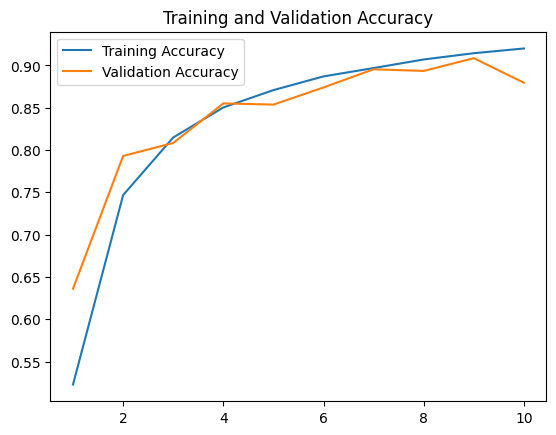

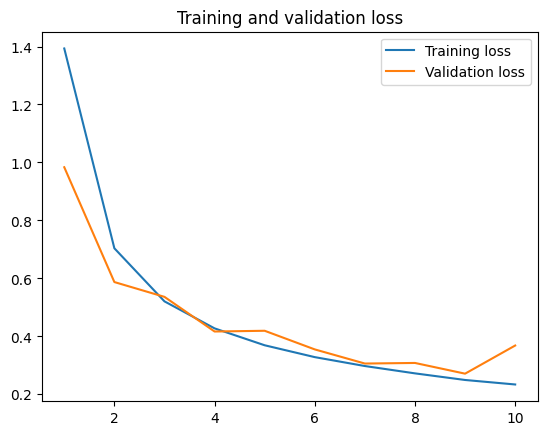

In [34]:
render_model_history(history, model_name=network_name)

194/194 [==============================] - 1s 6ms/step


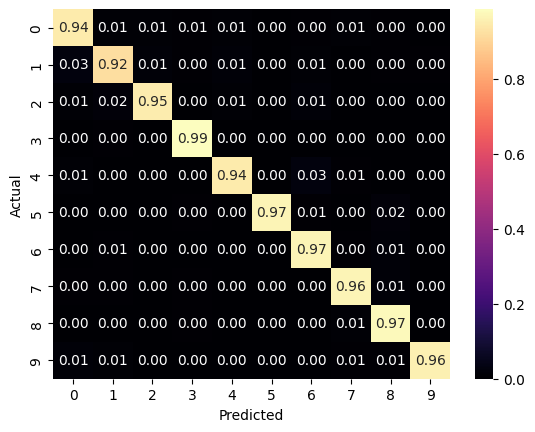

In [16]:
prediction = model.predict(X_test)
model_predictions = np.argmax(prediction, axis=1)
render_confusion_matrix(y_test, model_predictions)

# Class separability

665/665 [==============================] - 2s 3ms/step


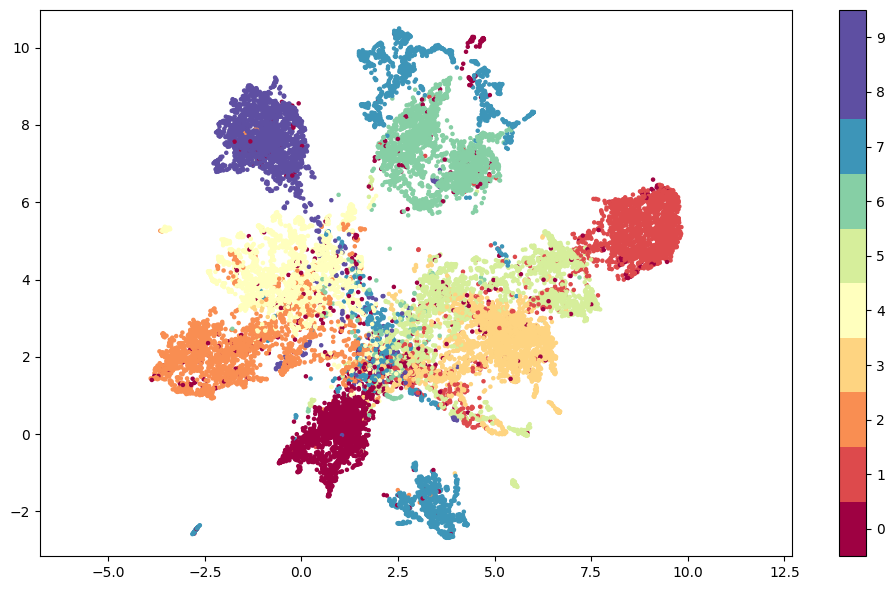

In [26]:
predict_model = keras.Model(model.input, model.layers[-2].output)
predicted_train = predict_model.predict(X_train[0])
render_umap_spectrum(predicted_train, y_train[0])

# Spatial labelling

In [26]:
predicted_swath = None
y_swath = None
num_processed_pixels = 0
batch_size = 20000

while True:
    X_train_swath, y_train_swath = hc_set.split_swath(patch_size=config.patch_size, patch_id=0, limit=batch_size, offset=num_processed_pixels)
    if X_train_swath is None:
        break
    if X_train_swath.shape[0] == 0:
        continue

    y_train_swath = reduce_labels_center(y_train_swath)
    predicted_labels = model.predict(X_train_swath)
    predicted_labels = np.argmax(predicted_labels, axis=1)

    if predicted_swath is None:
        predicted_swath = predicted_labels
        y_swath = y_train_swath
    else:
        predicted_swath = np.append(predicted_swath, predicted_labels)
        y_swath = np.append(y_swath, y_train_swath)

    num_processed_pixels += batch_size

|████████████████████████████████████████| 20000/20000 [100%] in 0.1s (230528.48/s)                                     
411/411 [==============================] - 2s 4ms/step
(13149,)
|████████████████████████████████████████| 20000/20000 [100%] in 0.1s (233465.21/s)                                     
605/605 [==============================] - 3s 4ms/step
(19349,)
|████████████████████████████████████████| 20000/20000 [100%] in 0.1s (260141.46/s)                                     
605/605 [==============================] - 2s 4ms/step
(19349,)
|████████████████████████████████████████| 20000/20000 [100%] in 0.1s (256748.78/s)                                     
605/605 [==============================] - 3s 4ms/step
(19338,)
|████████████████████████████████████████| 20000/20000 [100%] in 0.1s (226316.16/s)                                     
605/605 [==============================] - 2s 4ms/step
(19339,)
|████████████████████████████████████████| 20000/20000 [100%] in 0.1s (2340

In [60]:
label_diff = hc_set.compose_swath_evaluation(y_swath, predicted_swath, patch_size=config.patch_size)

[0 1 2 3 4 5 6 7 8]
[0 1]


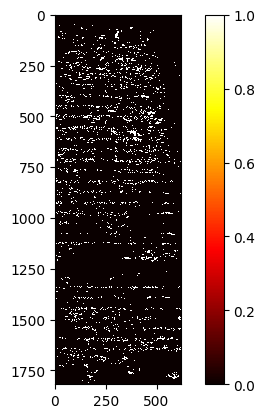

In [61]:
rendering.render_label_diff(label_diff, filename='swaths/' + 'red_0.png')

# Hypertuning

In [18]:
network_type = 'allopezr_2d'
#read_json_config(paths.config_file, network_type=network_type)

network_name = get_name(network_type)
num_classes = hc_set.get_num_classes()
img_shape = X_train[0][0].shape

# Reduce dataset
reduce_factor = 0.2
random_indices = np.random.choice(np.arange(len(X_train_augment)), int(len (X_train_augment) * reduce_factor), replace=False)

model = hypertune([X_train_augment[random_indices]], y_train_augmented[random_indices], network_type=network_type, model_name=network_name, validation_split=validation_split, callbacks=get_callback_list(model_name=network_name))

Trial 220 Complete [00h 07m 58s]
val_loss: 1.4392191171646118

Best val_loss So Far: 0.5229037404060364
Total elapsed time: 16h 12m 11s

Search: Running Trial #221

Value             |Best Value So Far |Hyperparameter
96                |32                |conv_1a
128               |16                |conv_2b
96                |16                |conv_3c
False             |False             |use_first_conv
0.0001            |0.01              |lr
0.4               |0.4               |intermediate_dropout
7                 |3                 |first_kernel_size
0.5               |0.1               |final_dropout
0.1               |0.1               |leaky_alpha
softplus          |exponential       |activation
2                 |2                 |strides
100               |34                |tuner/epochs
34                |12                |tuner/initial_epoch
2                 |4                 |tuner/bracket
2                 |3                 |tuner/round
0214              |0132    

KeyboardInterrupt: 